# ECLIPSE Basic Results Analysis Tutorial

This notebook demonstrates how to load and analyse instrument response simulation results from the ECLIPSE package.

## Overview

After running a Monte Carlo simulation with multiple parameter combinations, you'll have a results file containing:
- Fit statistics (mean, standard deviation, and first fit results)
- Ground truth values for comparison
- Parameter combinations tested
- Synthetic data arrays (photon counts and DN)

This notebook shows you how to:
1. Load simulation results
2. Explore available parameter combinations
3. Extract results for specific combinations
4. Analyze fit statistics to compute velocity and line width errors
5. Create SunPy maps for visualization

## 1. Import Required Libraries

First, let's import the necessary libraries and the ECLIPSE analysis functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import sunpy.map
from pathlib import Path

# Import euvst_response analysis functions
from euvst_response import (
    load_instrument_response_results,
    summary_table,
    get_results_for_combination,
    create_sunpy_maps_from_combo
)

/gpfs/data/fs70652/jamesm/venvs/solar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Simulation Results

Replace the path below with the path to your simulation results file.

In [2]:
# Path to your results file
results_file = "run/result/swc_exposure_scan.pkl"

# Load the results
results = load_instrument_response_results(results_file)

cube_reb = results.get("cube_reb")
cube_sim = results.get("cube_sim")

print(f"Loaded results successfully")

Loaded results successfully


## 3. Explore Available Parameter Combinations

Let's see what parameter combinations were simulated.

In [3]:
# Get a summary of all parameter combinations
summary_table(results)

Parameter Combination Summary
Slit (arcsec) Oxide (nm)   Carbon (nm)  Al (A)     CCD (C)    Stray Light  Exp (s)    PSF   Pinholes
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0.20         9.5          0.0          1485       -60.0      0            0.5        True  False   
0.20         9.5          0.0          1485       -60.0      0            1.0        True  False   
0.20         9.5          0.0          1485       -60.0      0            2.0        True  False   
0.20         9.5          0.0          1485       -60.0      0            5.0        True  False   
0.20         9.5          0.0          1485       -60.0      0            10.0       True  False   
0.20         9.5          0.0          1485       -60.0      0            20.0       True  False   
0.20         9.5          0.0          1485       -60.0      0            40.0       True  False   
0.20         

## 4. Extract Results for a Specific Parameter Combination

Now let's get results for a specific parameter combination. You can specify the exact parameters you want, or use defaults.

In [4]:
# Get results for a specific parameter combination
combination_results = get_results_for_combination(
    results,
    exposure=80 * u.s
    # Add other parameters as needed for a unique simulation, e.g.:
    # c_thickness=0 * u.AA,
    # ccd_temperature=-60.0 * u.deg_C
)

print("Selected parameter combination:")
for key, value in combination_results['parameters'].items():
    print(f"  {key}: {value}")

Selected parameter combination:
  slit_width: 0.2 arcsec
  oxide_thickness: 95.0 Angstrom
  c_thickness: 0.0 Angstrom
  aluminium_thickness: 1485.0 Angstrom
  ccd_temperature: -60.0 deg_C
  vis_sl: 0.0 ph / (s cm2)
  exposure: 80.0 s
  psf: True
  enable_pinholes: False
  pinhole_sizes: []
  pinhole_positions: []


## 5. Create SunPy Maps

Now let's create SunPy maps for spatial visualization. We need to provide a cube with helioprojective WCS coordinates.

In [5]:
# Set the rest wavelength for velocity calculations (Fe XII line)
rest_wavelength = 195.119 * u.AA

# Create maps for DN data (e.g. fitted velocity after electronic effects)
maps_dn = create_sunpy_maps_from_combo(
    combination_results,
    cube_reb,
    rest_wavelength=rest_wavelength,
    data_type="dn"
)

print("DN maps created successfully")
print(f"Available DN maps: {list(maps_dn.keys())}")

# Create maps for photon data (e.g. fitted velocity before electronic effects)
maps_photon = create_sunpy_maps_from_combo(
    combination_results,
    cube_reb,
    rest_wavelength=rest_wavelength,
    data_type="photon"
)

print("Photon maps created successfully")
print(f"Available photon maps: {list(maps_photon.keys())}")

DN maps created successfully
Available DN maps: ['total_photons', 'total_dn', 'velocity_from_fit', 'velocity_mean', 'velocity_std', 'velocity_err', 'line_width_from_fit', 'line_width_mean', 'line_width_std']
Photon maps created successfully
Available photon maps: ['total_photons', 'total_dn', 'velocity_from_fit', 'velocity_mean', 'velocity_std', 'velocity_err', 'line_width_from_fit', 'line_width_mean', 'line_width_std']


## 6. Create Histogram Plots

Let's visualize the velocity and error distributions. 

1. The standard deviation in the between all the Monte Carlo runs is used to estimate the uncertainty in the velocity measurement.
2. The difference between the Doppler velocity fitted before and after detector effects is used to estimate the systematic error in the velocity measurement (i.e. from the PSF).

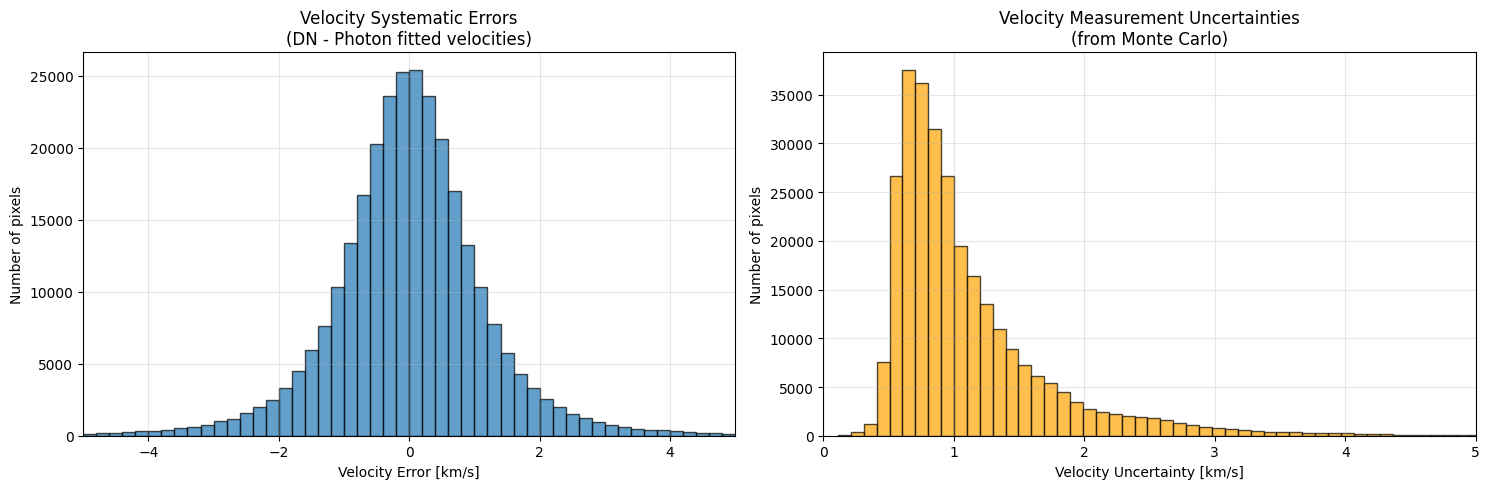

In [6]:
# Plot velocity analysis histograms using the SunPy maps
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Velocity errors (systematic errors from detector effects)
# Compare fitted velocities between photon and DN data
v_photon = maps_photon['velocity_from_fit'].data.flatten()
v_dn = maps_dn['velocity_from_fit'].data.flatten()

# Calculate velocity errors (difference between photon and DN velocities)
v_errors = (v_dn - v_photon)
v_errors_clipped = np.clip(v_errors, -10, 10)  # Clip to reasonable range

axes[0].hist(v_errors_clipped, bins=100, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Velocity Error [km/s]')
axes[0].set_ylabel('Number of pixels')
axes[0].set_title('Velocity Systematic Errors\n(DN - Photon fitted velocities)')
axes[0].set_xlim(-5, 5)
axes[0].grid(True, alpha=0.3)

# Velocity uncertainties from Monte Carlo
v_std_dn = maps_dn['velocity_std'].data.flatten()
v_std_clipped = np.clip(v_std_dn, 0, 10)  # Clip to reasonable range

axes[1].hist(v_std_clipped, bins=100, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Velocity Uncertainty [km/s]')
axes[1].set_ylabel('Number of pixels')
axes[1].set_title('Velocity Measurement Uncertainties\n(from Monte Carlo)')
axes[1].set_xlim(0, 5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Display SunPy Maps

Now let's display the SunPy maps we created above.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


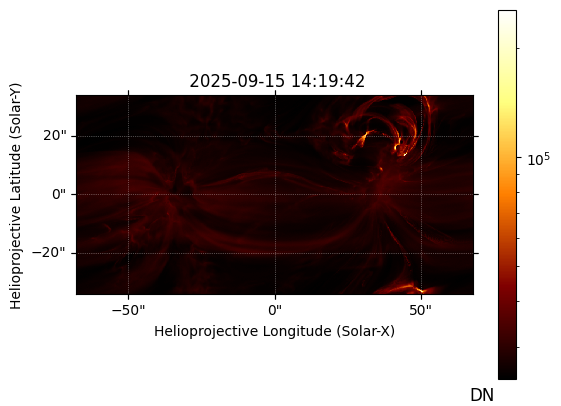

In [7]:
# Make a quicklook of the DN map
maps_dn['total_dn'].peek()